In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

from scipy.stats import betabinom
from scipy.optimize import minimize

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"

## Simple data

In [2]:
n = 1000
p = 1200 ## make this larger to increase difficulty
n_top = 20 ## number of top words in each topic
k = 3
doc_len = 80
np.random.seed(123)

X, Atrue, Ftrue, p0, Ltrue = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len, 
                                           n_top = n_top, returnL=True)
w_idx = np.where(X.sum(axis = 0) > 0)[0]
X = X[:,w_idx]

Pi_true = Ltrue @ Ftrue.T



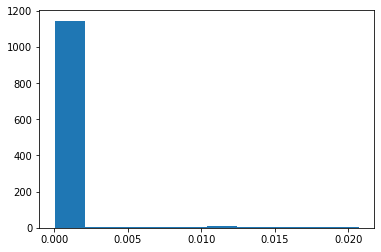

In [3]:
Pi = X / X.sum(axis = 1)[:, None]
C = Pi.T @ Pi / n

plt.hist(C.sum(axis = 1))
plt.show()

Cbar = C / C.sum(axis = 1).max()

In [4]:
S, _, _ = findS(Cbar, k)
S

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0121 seconds



array([41,  2, 30])

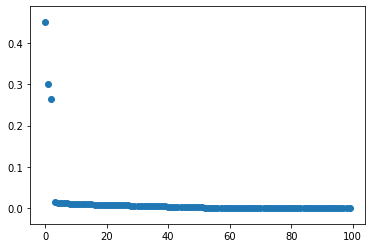

In [5]:
sigma = np.linalg.svd(Cbar, full_matrices=False, compute_uv=False)

plt.scatter([i for i in range(100)], sigma[:100])
plt.show()

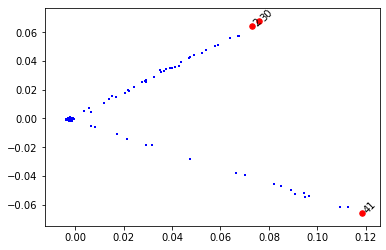

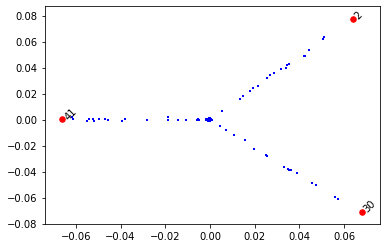

In [6]:

Cbar_pj = pca_proj(Cbar)
vis_extremal_pca(Cbar_pj, S, [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S, [1, 2], annotate=True, fontsize=10)

## More realistic data

In [7]:
## load data
dataname = "sla"
k = 6
rate=3

datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
X = fitted['X'].toarray()
L = fitted['Ltrue']
F = fitted['Ftrue']

n, p = X.shape

In [8]:
Pi_true = L @ F.T
Pi_true_bar = Pi_true / Pi_true.sum(axis = 0)
Strue, _, _ = findS(Pi_true_bar.T, k)
Strue

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.2427 seconds



array([2163, 7914, 7436, 5492, 6094, 4873])

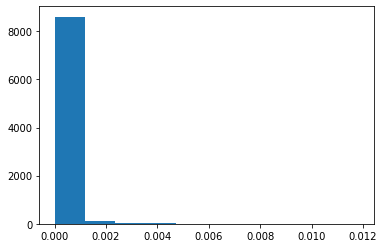

In [9]:
Pi = X / X.sum(axis = 1)[:, None]
C = Pi.T @ Pi / n

plt.hist(C.sum(axis = 1))
plt.show()

Cbar = C / C.sum(axis = 1).max()

In [10]:
svd = TruncatedSVD(n_components=30, random_state=42)
svd.fit(Cbar)


TruncatedSVD(algorithm='randomized', n_components=30, n_iter=5, random_state=42,
             tol=0.0)

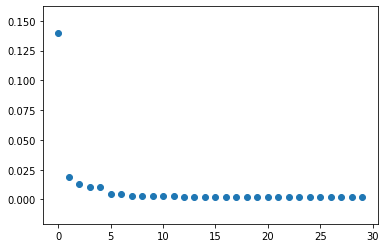

In [11]:
plt.scatter([i for i in range(30)], svd.singular_values_)
plt.show()

In [12]:
S, _, _ = findS(Cbar, k)
S

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2175 seconds



array([4909, 7914, 1821, 2637, 4923, 6569])

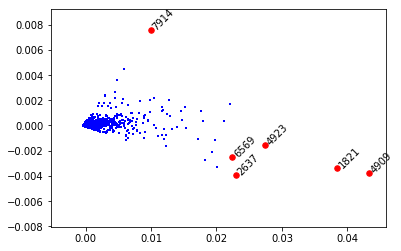

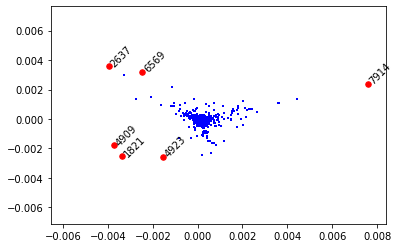

In [13]:
Cbar_pj = pca_proj(Cbar)
vis_extremal_pca(Cbar_pj, S, [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S, [1, 2], annotate=True, fontsize=10)

In [14]:
C_true = Pi_true.T @ Pi_true / n
pca = PCA(n_components=10)
pca.fit(C_true / C_true.sum(axis = 1).max())
Cbar_pj_true= pca.transform(Cbar)
Ctrue_pj = pca.transform(C_true / C_true.sum(axis = 1).max())
Ctrue_bar_pj = Cbar_proj(C_true)

In [15]:
S0, _, _ = findS(C_true / C_true.sum(axis = 1).max(), k)
S0

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2000 seconds



array([4909, 7914, 2637, 7071, 2205, 8131])

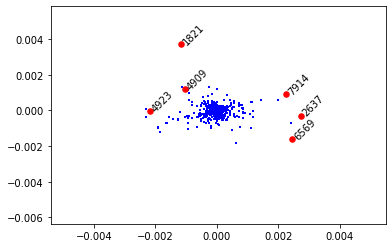

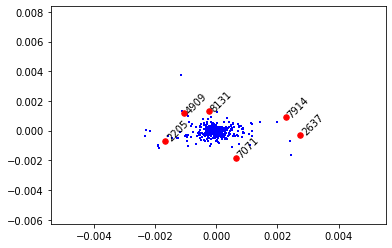

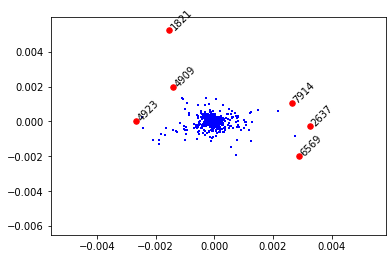

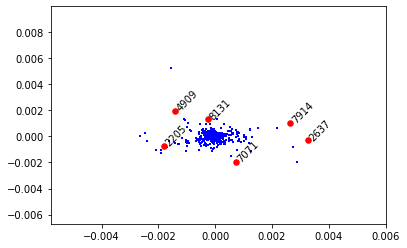

In [16]:
which_dim = [2, 3]
vis_extremal_pca(Ctrue_pj, S, which_dim, annotate=True, fontsize=10)
vis_extremal_pca(Ctrue_pj, S0,which_dim, annotate=True, fontsize=10)

vis_extremal_pca(Cbar_pj_true, S, which_dim, annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj_true, S0, which_dim, annotate=True, fontsize=10)

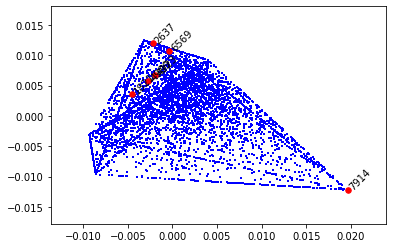

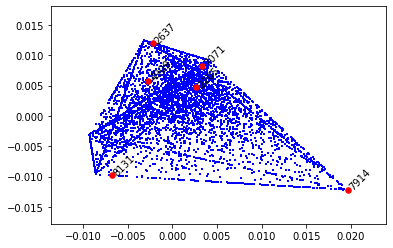

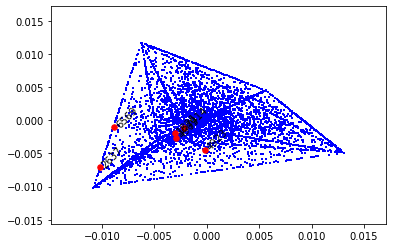

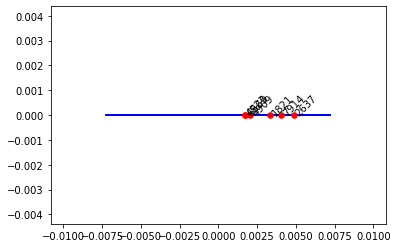

In [17]:
vis_extremal_pca(Ctrue_bar_pj, S, [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Ctrue_bar_pj, S0, [0, 1], annotate=True, fontsize=10)


vis_extremal_pca(Ctrue_bar_pj, S, [2, 3], annotate=True, fontsize=10)
vis_extremal_pca(Ctrue_bar_pj, S, [4, 5], annotate=True, fontsize=10)




In [18]:
F[S0,:].round(4)

array([[0.009 , 0.0006, 0.021 , 0.0092, 0.0161, 0.0104],
       [0.    , 0.0242, 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.0207, 0.0042, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.0135, 0.    , 0.0012],
       [0.0127, 0.0053, 0.0073, 0.    , 0.0021, 0.0018],
       [0.    , 0.0006, 0.    , 0.    , 0.    , 0.0114]])

In fact assumption won't hold!!

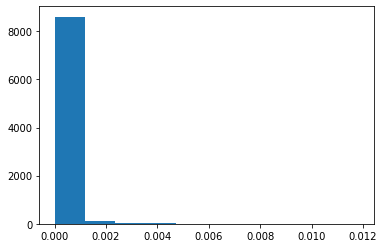

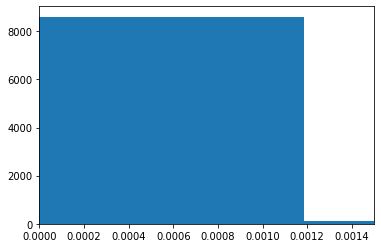

In [19]:
plt.hist(C.sum(axis = 1))
plt.show()

plt.hist(C.sum(axis = 1))
plt.xlim([0, 0.0015])
plt.show()

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 1.2371 seconds

[7105 7914 7436 7071 6094 8131]
[2163 7914 7436 5492 6094 4873]


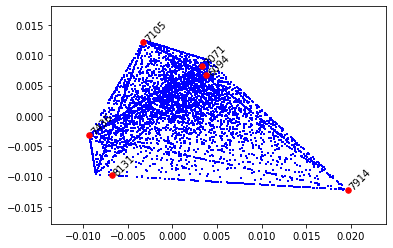

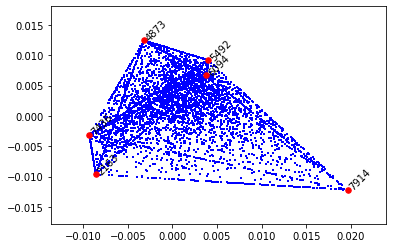

[[0.    0.    0.007 0.    0.    0.   ]
 [0.    0.024 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.008 0.   ]
 [0.    0.    0.    0.014 0.    0.001]
 [0.004 0.    0.    0.    0.    0.   ]
 [0.    0.001 0.    0.    0.    0.011]]
[[0.    0.    0.    0.    0.    0.004]
 [0.    0.024 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.008 0.   ]
 [0.    0.    0.    0.002 0.    0.   ]
 [0.004 0.    0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.   ]]


In [29]:
cutoff = 0.0008
d = C.sum(axis = 1)
d[d < cutoff] = cutoff
Cbar2 = C / d[:, None]


S2, _, _ = findS(Cbar2, k)
print(S2)

print(Strue)

vis_extremal_pca(Ctrue_bar_pj, S2, [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Ctrue_bar_pj, Strue, [0, 1], annotate=True, fontsize=10)


print(F[S2,:].round(3))

print(F[Strue,:].round(3))

In [25]:
pca = PCA(n_components=10)
Cbar2_pca = pca.fit_transform(Cbar2)

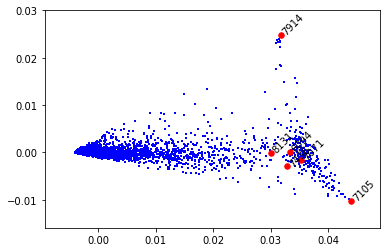

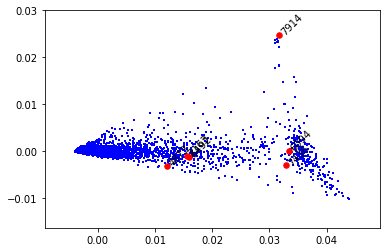

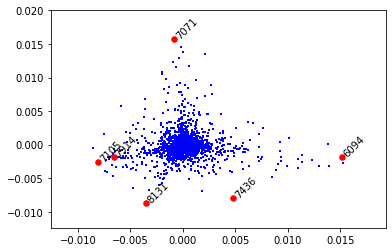

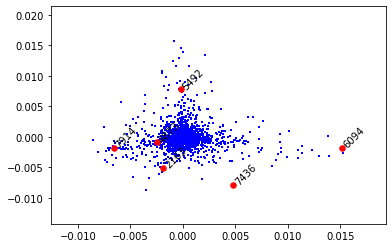

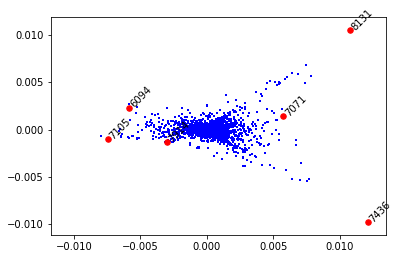

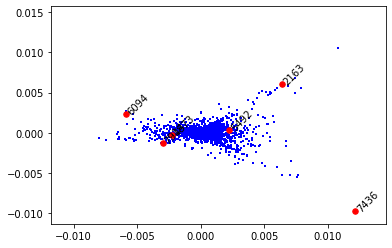

In [26]:
vis_extremal_pca(Cbar2_pca, S2, [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar2_pca, Strue, [0, 1], annotate=True, fontsize=10)

vis_extremal_pca(Cbar2_pca, S2, [2, 3], annotate=True, fontsize=10)
vis_extremal_pca(Cbar2_pca, Strue, [2, 3], annotate=True, fontsize=10)


vis_extremal_pca(Cbar2_pca, S2, [4, 5], annotate=True, fontsize=10)
vis_extremal_pca(Cbar2_pca, Strue, [4, 5], annotate=True, fontsize=10)
